### Check time evolution of terms in the vorticity formulation
This notebook finds the terms in the vorticity formulation and makes of a video of their time-evolution.

In [1]:
import os
import sys
sys.path.append("../") # go to parent dir
import glob
import time
import pathlib
import logging
import numpy as np
from dedalus.tools.config import config
from simple_sphere import SimpleSphere, TensorField, TensorSystem
import equations
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import logging
from mpl_toolkits import mplot3d
logger = logging.getLogger(__name__)
from matplotlib.animation import FFMpegWriter
from dedalus.extras import plot_tools
import copy as cp

#add path to data folder
input_folder = "/Users/Rohit/Documents/research/active_matter_spheres/scripts/data/sphere66"
output_folder = "/Users/Rohit/Documents/research/active_matter_spheres/scripts/videos"

#define the simulation parameters
Omega, Lmid, kappa = 250, 4, 1 

first_frame = 1
last_frame = len(glob.glob1("".join([input_folder,'/']),"*.npz"))
last_frame = 500
dpi = 256
fields = ['om','v_ph']

t_arr = np.zeros(last_frame - first_frame + 1)

### Define the active dispersion relation

In [2]:
#get gammas from Lmid and kappa setting R=1 and tau=1
def get_gammas(Lmid, kappa):
    a = 0.25*(Lmid**2*kappa**2 - 0.5*(2*np.pi*Lmid+1)**2)**2 + 17*17/16 - (34/16)*(2*np.pi*Lmid+1)**2
    b = (17/4 - 0.25*(2*np.pi*Lmid+1)**2)**2
    c = 1/(17/4 - 0.25*(2*np.pi*Lmid + 1)**2 - 2)
    gamma0 = a*c/(a-b)
    gamma2 = -2*np.sqrt(b)*c/(a-b)
    gamma4 = c/(a-b)
    
    return gamma0, gamma2, gamma4

#get the value of the dispersion polynomial
def get_f(Lmid, kappa, x):
    gamma0, gamma2, gamma4 = get_gammas(Lmid, kappa)
    f = gamma0 - gamma2*x + gamma4*x**2
    return f

F = lambda x: get_f(Lmid, kappa, x)


In [17]:
## find psi and activity term in real space 

for ind in range(first_frame, last_frame + 1, 1):
    if np.mod(ind,100)==0: logger.info('Frame:%i'%(ind))
    
    with np.load(os.path.join(input_folder, 'output_%i.npz' %(ind))) as file:
        if ind == first_frame:
            phi = file['phi']
            theta = file['theta']
            L_max = len(theta)-1
            S_max = 4
            simplesphere = SimpleSphere(L_max, S_max)
            omega = TensorField(simplesphere, rank=0)
            
            psi = TensorField(simplesphere, rank=0)
            activity = TensorField(simplesphere, rank=0)
            
            om_arr = np.zeros((t_arr.shape[0], 2*(L_max+1), L_max+1))
            psi_arr = np.zeros_like(om_arr)
            activity_arr = np.zeros_like(om_arr)
            vph_arr = np.zeros_like(om_arr)
            

        om_arr[ind-1, :, :] = file['om']
        vph_arr[ind-1, :, :] = file['v_ph']
        time = file['t'][0]
        t_arr[ind-1] = time
        
        # assign loaded data
        omega.component_fields[0]['g'] = file['om']
        # spectral transform
        omega.forward_phi()
        omega.forward_theta()
        coeffs = omega.coeffs
        
        psi_coeffs = cp.deepcopy(coeffs)
        activity_coeffs = cp.deepcopy(coeffs)
        for dm, m in enumerate(simplesphere.local_m):
            for ell in range(m, L_max+1):
                if ell != 0:
                    psi_coeffs[dm][ell-m] = psi_coeffs[dm][ell-m]/(ell*(ell+1))
                activity_coeffs[dm][ell-m] = F(-ell*(ell+1) + 4)*(-ell*(ell+1) + 2)*activity_coeffs[dm][ell-m]
                
        psi.coeffs = cp.deepcopy(psi_coeffs)
        activity.coeffs = cp.deepcopy(activity_coeffs)
        
        # backward transforms 
        psi.backward_theta()
        psi.backward_phi()
        activity.backward_theta()
        activity.backward_phi()
        
        psi_arr[ind-1, :, :] = psi.component_fields[0]['g']
        activity_arr[ind-1, :, :] = activity.component_fields[0]['g']
            
            

2019-07-22 17:20:47,231 __main__ 0/1 INFO :: Frame:100
2019-07-22 17:21:46,581 __main__ 0/1 INFO :: Frame:200
2019-07-22 17:22:48,999 __main__ 0/1 INFO :: Frame:300
2019-07-22 17:23:39,483 __main__ 0/1 INFO :: Frame:400
2019-07-22 17:24:39,700 __main__ 0/1 INFO :: Frame:500


### Find terms in the vorticity formulation using finite differences


In [18]:
nonlinear_arr = np.zeros_like(om_arr)
rotation_arr = np.zeros_like(om_arr)

dphi = phi[1] - phi[0]
dtheta = theta[1] - theta[0]

psi_th = np.zeros_like(om_arr)
psi_phi = np.zeros_like(om_arr)
om_th = np.zeros_like(om_arr)
om_phi = np.zeros_like(om_arr)

ttt, phphph, ththth = np.meshgrid(t_arr, phi, theta, indexing='ij')

#phi derivatives
for ind_phi, ph in enumerate(phi):
    
    if ind_phi==0: right, left = ind_phi+1, ind_phi
    else: right, left = ind_phi, ind_phi-1

    psi_phi[:, ind_phi, :] = (psi_arr[:, right, :] - psi_arr[:, left, :])/dphi
    om_phi[:, ind_phi, :] = (om_arr[:, right, :] - om_arr[:, left, :])/dphi
    
#theta derivatives 
for ind_th, th in enumerate(theta):
    
    if ind_th==0: right, left = ind_th+1, ind_th
    else: right, left = ind_th, ind_th-1
        
    psi_th[:, :, ind_th] = (psi_arr[:, :, right] - psi_arr[:, :, left])/dtheta
    om_th[:, :, ind_th] = (om_arr[:, :, right] - om_arr[:, :, left])/dtheta

#nonlinear jacobian term
nonlinear_arr = (psi_phi * om_th - om_phi * psi_th)/np.sin(ththth)
#rotation term 
rotation_arr = 2*Omega*psi_phi


### Set the max of the fields

In [28]:
data_dict = {'zeta': om_arr, 'v_ph': vph_arr, 'zeta_t': -nonlinear_arr + activity_arr + rotation_arr, \
             'activity': activity_arr, 'nonlinear': -nonlinear_arr, 'rotation': rotation_arr}

fields = data_dict.keys()
max_vals = {key: 0 for key in fields}
clims = {key: 0 for key in fields}

for field in fields:
    for i in range(first_frame, last_frame + 1, 1):
        fieldval = data_dict[field][i-1, :, :]
        max_vals[field] = max(max_vals[field], np.max(fieldval))

for field in fields:
    clims[field] = 0.75*max_vals[field]
    
for key in data_dict.keys(): 
    if (key is not 'zeta') and (key is not 'v_ph'): clims[key] = 1500

### Make video

2019-07-22 17:54:34,171 matplotlib.animation 0/1 INFO :: MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '2200x1600', '-pix_fmt', 'rgba', '-r', '15', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-metadata', 'title=Movie', '-metadata', 'artist=Matplotlib', '-metadata', 'comment=Movie support!', '-y', '/Users/Rohit/Documents/research/active_matter_spheres/scripts/videos/time_evolve.mp4']
2019-07-22 17:54:41,868 __main__ 0/1 INFO :: Frame: 10
2019-07-22 17:54:49,726 __main__ 0/1 INFO :: Frame: 20
2019-07-22 17:54:57,407 __main__ 0/1 INFO :: Frame: 30
2019-07-22 17:55:06,857 __main__ 0/1 INFO :: Frame: 40
2019-07-22 17:55:17,052 __main__ 0/1 INFO :: Frame: 50
2019-07-22 17:55:24,967 __main__ 0/1 INFO :: Frame: 60
2019-07-22 17:55:32,549 __main__ 0/1 INFO :: Frame: 70
2019-07-22 17:55:42,449 __main__ 0/1 INFO :: Frame: 80
2019-07-22 17:55:49,952 __main__ 0/1 INFO :: Frame: 90
2019-07-22 17:55:57,132 __main__ 0/1 INFO :: Frame: 100
201

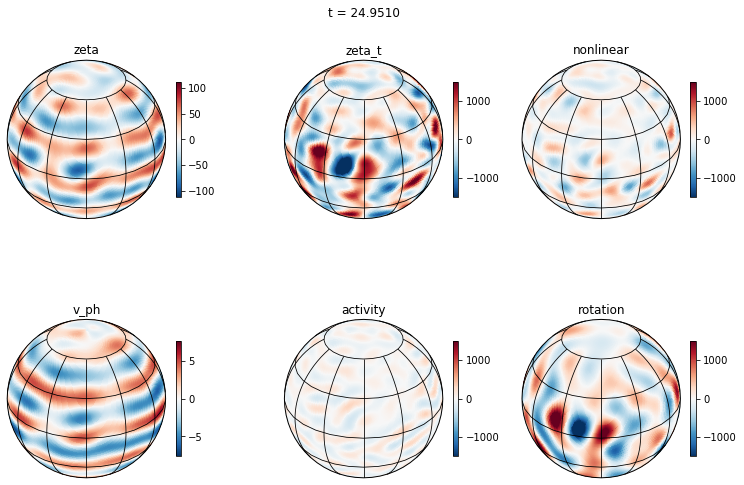

In [31]:
plt.rc('text', usetex=False)

fig = plt.figure(figsize=(11,8))
proj = ccrs.Orthographic(central_longitude=0, central_latitude=30)

FPS = 15
metadata = dict(title='Movie', artist='Matplotlib', comment='Movie support!')
writer = FFMpegWriter(fps=FPS, metadata=metadata)
edgecolor = 'k'
axes1 = plt.axes((0.05, 0.55, 0.25, 0.4), projection=proj)
axes2 = plt.axes((0.05, 0.1, 0.25, 0.4), projection=proj)
axes3 = plt.axes((0.4, 0.55, 0.25, 0.4), projection=proj)
axes4 = plt.axes((0.4, 0.1, 0.25, 0.4), projection=proj)
axes5 = plt.axes((0.7, 0.55, 0.25, 0.4), projection=proj)
axes6 = plt.axes((0.7, 0.1, 0.25, 0.4), projection=proj)

images = [None for i in range(6)]

thth, phiphi = np.meshgrid(theta, phi)

dpi=200

with writer.saving(fig, "%s/time_evolve.mp4" %(output_folder), dpi):
    
    for i in range(first_frame+1, last_frame + 1, 1):
        if i%10==0: logger.info('Frame: %i' %(i))
        
        time = t_arr[i-1]

        """Plot fields """
        for num, field in enumerate(data_dict.keys()):
            axes = [axes1, axes2, axes3, axes4, axes5, axes6][num]
            image = images[num]
            data = data_dict[field][i-1, :, :]

            # Create plot
            if i == first_frame+1:
                lon = (phi + phi[1]/2 - np.pi) * 180 / np.pi
                lat = (np.pi/2 - theta) * 180 / np.pi
                xmesh, ymesh = plot_tools.quad_mesh(lon, lat)
                image = axes.pcolormesh(xmesh, ymesh, data.T, cmap='RdBu_r', transform=ccrs.PlateCarree())
                title = fig.suptitle('t = %.4f' %time)
                axes.gridlines(xlocs=np.arange(0, 361, 30), ylocs=np.arange(-60, 61, 30), color='k')
                axes.set_global()
                axes.outline_patch.set_edgecolor(edgecolor)
                fig.colorbar(image, ax=axes, shrink=0.5)
                axes.set_title(field)

            #Update plot
            else:
                image.set_array(data.T.ravel())
                title.set_text('t = %.4f' %time)

            if clims:
                image.set_clim(-clims[field], clims[field])
            else:
                clim_i = np.max(np.abs(data))
                image.set_clim(-clim_i, clim_i)

            images[num] = image
                
            
        writer.grab_frame()

In [27]:
clims

{'zeta': 111.78869281618346,
 'v_ph': 7.6068853367783955,
 'zeta_t': 1060097.6817866317,
 'activity': 1060111.4647964006,
 'nonlinear': 2321.6450379544044,
 'rotation': 2691.559859831357}